<a href="https://colab.research.google.com/github/Afix0/BP/blob/main/Embeddings_vs_Subgroups001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Dependencies
import numpy as np
import pandas as pd
from collections import Counter
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import export_text
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import LabelEncoder
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
#Parameters:
"""
vector_space_dimention  ... dimention of the embedding vector space
n_clusters              ... number of clusters to be found
max_depth               ... maximal depth of the decision tree
test_size               ... size of the test set for training the decision tree
mixed_threashold        ... threshold for classifying a cluster as mixed
"""


vector_space_dimention = 30
n_clusters = 12
max_depth = 5
test_size = 0.2
mixed_threashold = 0.8


In [3]:
#Data augemntation
mushroom = fetch_ucirepo(id=73)
mushroom_df = pd.DataFrame(data=mushroom.data.features)

def preprocess_mushroom_data(df):

    mapping = {
    'cap-shape': {'b': 'bell', 'c': 'conical', 'x': 'convex', 'f': 'flat', 'k': 'knobbed', 's': 'sunken'},
    'cap-surface': {'f': 'fibrous', 'g': 'grooves', 'y': 'scaly', 's': 'smooth'},
    'cap-color': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'r': 'green', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'bruises': {'t': 'bruises', 'f': 'no bruises'},
    'odor': {'a': 'almond', 'l': 'anise', 'c': 'creosote', 'y': 'fishy', 'f': 'foul', 'm': 'musty', 'n': 'none', 'p': 'pungent', 's': 'spicy'},
    'gill-attachment': {'a': 'attached', 'd': 'descending', 'f': 'free', 'n': 'notched'},
    'gill-spacing': {'c': 'close', 'w': 'crowded', 'd': 'distant'},
    'gill-size': {'b': 'broad', 'n': 'narrow'},
    'gill-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'g': 'gray', 'r': 'green', 'o': 'orange', 'p': 'pink', 'u': 'purple', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-shape': {'e': 'enlarging', 't': 'tapering'},
    'stalk-root': {'b': 'bulbous', 'c': 'club', 'u': 'cup', 'e': 'equal', 'z': 'rhizomorphs', 'r': 'rooted', '?': 'missing'},
    'stalk-surface-above-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-surface-below-ring': {'f': 'fibrous', 'y': 'scaly', 'k': 'silky', 's': 'smooth'},
    'stalk-color-above-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'stalk-color-below-ring': {'n': 'brown', 'b': 'buff', 'c': 'cinnamon', 'g': 'gray', 'o': 'orange', 'p': 'pink', 'e': 'red', 'w': 'white', 'y': 'yellow'},
    'veil-type': {'p': 'partial', 'u': 'universal'},
    'veil-color': {'n': 'brown', 'o': 'orange', 'w': 'white', 'y': 'yellow'},
    'ring-number': {'n': 'none', 'o': 'one', 't': 'two'},
    'ring-type': {'c': 'cobwebby', 'e': 'evanescent', 'f': 'flaring', 'l': 'large', 'n': 'none', 'p': 'pendant', 's': 'sheathing', 'z': 'zone'},
    'spore-print-color': {'k': 'black', 'n': 'brown', 'b': 'buff', 'h': 'chocolate', 'r': 'green', 'o': 'orange', 'u': 'purple', 'w': 'white', 'y': 'yellow'},
    'population': {'a': 'abundant', 'c': 'clustered', 'n': 'numerous', 's': 'scattered', 'v': 'several', 'y': 'solitary'},
    'habitat': {'g': 'grasses', 'l': 'leaves', 'm': 'meadows', 'p': 'paths', 'u': 'urban', 'w': 'waste', 'd': 'woods'}
}

    for column, mapping in mapping.items():
        df[column] = df[column].replace(mapping)

    return df

mushroom_df = preprocess_mushroom_data(mushroom_df).astype(str)

for column in mushroom_df.columns:
    split_columns = column.split("-")
    jointed_columns = ' '.join(split_columns)
    mushroom_df[column] = mushroom_df[column].apply(lambda x: f"{jointed_columns} is {x}")

#Comparison dataframe
mushroom_raw = pd.DataFrame(data=mushroom.data.features)
mushroom_raw = preprocess_mushroom_data(mushroom_raw)
mushroom_raw = mushroom_raw.fillna('unknown')

In [4]:
#Word2Vec training and clustering
sentences = []
for i in range(len(mushroom_df)):
    sentence = []
    for word in mushroom_df.iloc[i]:
        sentence.append(word)
    sentences.append(sentence)

def sentence_embedding(sentence, model):
    word_embeddings = []
    for word in sentence:
        word_embeddings.append(model.wv[word])
    return np.mean(word_embeddings, axis=0)

model = Word2Vec(sentences, min_count=1, vector_size=vector_space_dimention, window=5)
embeddings = np.array([sentence_embedding(sentence, model) for sentence in sentences])
labels_aglomerative_average = AgglomerativeClustering(n_clusters= n_clusters, metric = 'cosine', linkage='average').fit_predict(embeddings)

In [5]:
#Decission tree training
mushroom_classify = mushroom_raw.assign(cluster = labels_aglomerative_average)

encoder = OneHotEncoder()
X = mushroom_classify.drop(columns=['cluster'])
X_encoded = encoder.fit_transform(mushroom_classify[['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat' ]]).toarray()
y = mushroom_classify['cluster']
X_df = pd.DataFrame(X, columns=encoder.get_feature_names_out())


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=test_size, random_state=73, stratify=y)

clf = DecisionTreeClassifier(max_depth=max_depth, random_state=73)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.912
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       352
           1       0.57      1.00      0.73        77
           2       0.66      1.00      0.79       155
           3       0.00      0.00      0.00         2
           4       1.00      0.81      0.89       346
           5       0.00      0.00      0.00        58
           6       1.00      1.00      1.00       346
           7       0.00      0.00      0.00         3
           8       1.00      1.00      1.00       259
           9       0.73      0.58      0.65        19
          10       0.88      1.00      0.93         7
          11       0.00      0.00      0.00         1

    accuracy                           0.91      1625
   macro avg       0.57      0.61      0.58      1625
weighted avg       0.90      0.91      0.90      1625



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
#Adding a target class
mapping_targets = {'p': 'poisonous', 'e': 'edible'}

targets_df = pd.DataFrame(data=mushroom.data.targets)
targets_df.columns = ['class']
targets_df['class'] = targets_df['class'].map(mapping_targets)

In [7]:
#Classifying clusters with respect to target

def classify_clusters(data_frame, target_df, mixed_threshold, cluster_labels):

    cluster_to_class_counts = {}
    for i, label in enumerate(cluster_labels):
        cluster_to_class_counts.setdefault(label, {})
        class_label = target_df['class'][i]
        cluster_to_class_counts[label][class_label] = cluster_to_class_counts[label].get(class_label, 0) + 1

    cluster_classifications = {}
    for cluster, class_counts in cluster_to_class_counts.items():
        total_count = sum(class_counts.values())
        dominant_class, dominant_count = max(class_counts.items(), key=lambda x: x[1])
        relative_frequency = dominant_count / total_count

        if relative_frequency >= mixed_threshold:
            cluster_classifications[cluster] = dominant_class
        else:
            cluster_classifications[cluster] = 'mixed'

    return dict(sorted(cluster_classifications.items()))


classify_clusters(mushroom_df, targets_df, mixed_threashold, cluster_labels=labels_aglomerative_average)

{0: 'poisonous',
 1: 'edible',
 2: 'edible',
 3: 'poisonous',
 4: 'mixed',
 5: 'edible',
 6: 'edible',
 7: 'edible',
 8: 'poisonous',
 9: 'edible',
 10: 'poisonous',
 11: 'poisonous'}

In [8]:
def extract_rules(tree, feature_names, class_names, cluster_classifications, node=0, depth=0, rule=[], rules_list=None):

    if rules_list is None:
        rules_list = []

    left_child = tree.tree_.children_left[node]
    right_child = tree.tree_.children_right[node]
    threshold = tree.tree_.threshold[node]
    feature = tree.tree_.feature[node]
    value = tree.tree_.value[node]

    if left_child == -1 and right_child == -1:
        class_label = class_names[value.argmax()]
        rules_list.append((class_label, " AND ".join(rule)))
        return rules_list

    if left_child != -1:
        left_rule = rule + [f"{feature_names[feature]} <= {threshold:.2f}"]
        extract_rules(tree, feature_names, class_names, cluster_classifications, left_child, depth + 1, left_rule, rules_list)

    if right_child != -1:
        right_rule = rule + [f"{feature_names[feature]} > {threshold:.2f}"]
        extract_rules(tree, feature_names, class_names, cluster_classifications, right_child, depth + 1, right_rule, rules_list)

    if depth == 0:
        sorted_rules = sorted(rules_list, key=lambda x: x[0])
        print("Rules for subgroups:")
        for class_label, rule_text in sorted_rules:
            if cluster_classifications.get(class_label, 'mixed') != 'mixed':
                print(f"Rule for subgroup '{class_label}' ({cluster_classifications[class_label]}): {rule_text}")

extract_rules(clf, list(X_df.columns), list(set(mushroom_classify['cluster'])), cluster_classifications=classify_clusters(mushroom_df, targets_df, mixed_threashold, cluster_labels=labels_aglomerative_average))

Rules for subgroups:
Rule for subgroup '0' (poisonous): gill-color_buff > 0.50
Rule for subgroup '1' (edible): gill-color_buff <= 0.50 AND ring-type_large <= 0.50 AND habitat_woods <= 0.50 AND stalk-root_equal <= 0.50 AND stalk-root_unknown > 0.50
Rule for subgroup '2' (edible): gill-color_buff <= 0.50 AND ring-type_large <= 0.50 AND habitat_woods <= 0.50 AND stalk-root_equal <= 0.50 AND stalk-root_unknown <= 0.50
Rule for subgroup '6' (edible): gill-color_buff <= 0.50 AND ring-type_large <= 0.50 AND habitat_woods > 0.50 AND gill-size_broad > 0.50 AND spore-print-color_white <= 0.50
Rule for subgroup '8' (poisonous): gill-color_buff <= 0.50 AND ring-type_large > 0.50
Rule for subgroup '9' (edible): gill-color_buff <= 0.50 AND ring-type_large <= 0.50 AND habitat_woods > 0.50 AND gill-size_broad <= 0.50 AND stalk-surface-below-ring_smooth <= 0.50
Rule for subgroup '10' (poisonous): gill-color_buff <= 0.50 AND ring-type_large <= 0.50 AND habitat_woods > 0.50 AND gill-size_broad > 0.50 AND

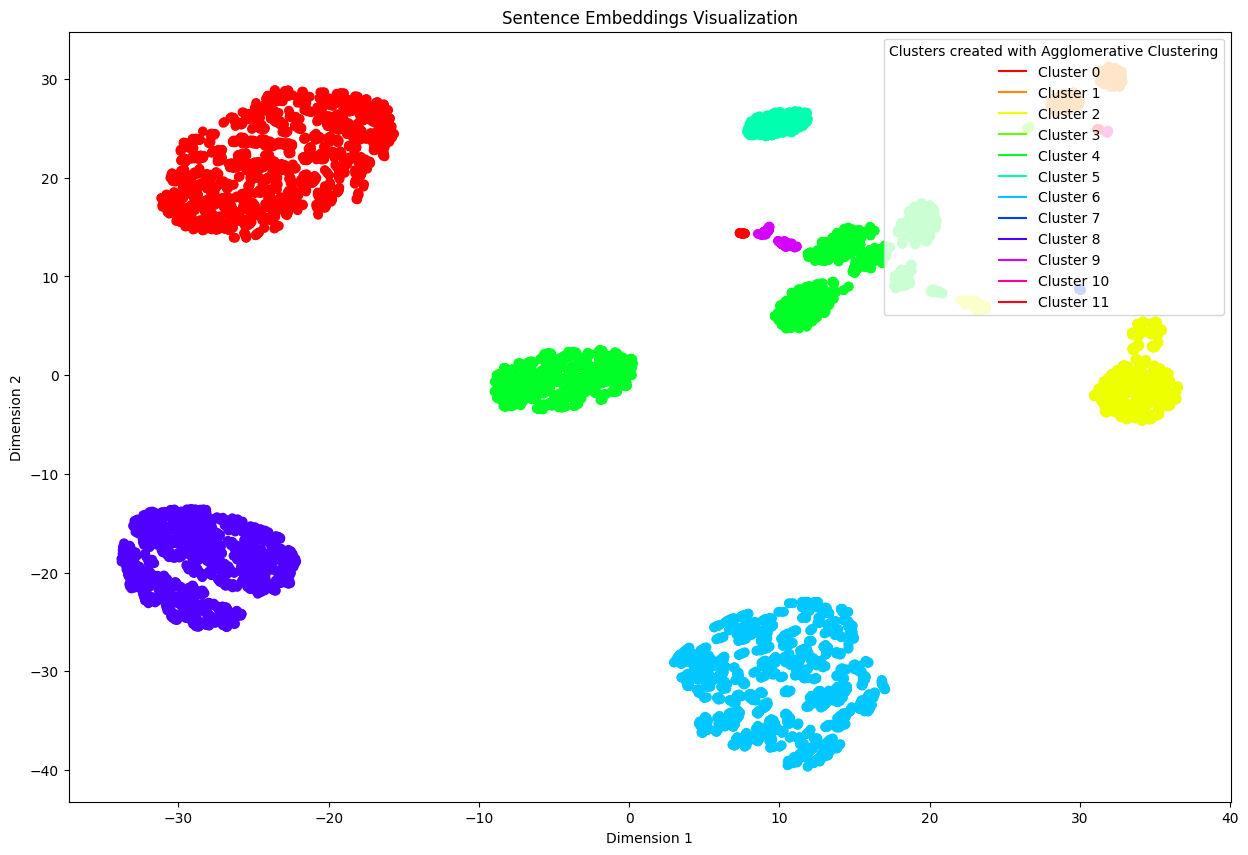

In [9]:
#Clusters visualization
def plot_sentence_embeddings(embeddings, cluster_labels=None, target_labels=None, clustering_method=None):
    plt.figure(figsize=(15, 10))
    tsne = TSNE(n_components=2, random_state= 73, perplexity=300, learning_rate=200, max_iter=1000)
    embeddings_2d = tsne.fit_transform(np.array(embeddings))
    cmap = plt.colormaps['hsv']


    if cluster_labels is not None and target_labels is None:
        n_clusters = len(set(cluster_labels))
        colors = cmap(np.linspace(0, 1, n_clusters))
        handles = [plt.Line2D([], [], color=color) for color in colors]
        labels = [f"Cluster {i}" for i in range(n_clusters)]
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors[cluster_labels])

        plt.legend(handles=handles, labels=labels, title=f"Clusters created with {clustering_method}", loc = "upper right")

    elif target_labels is not None and cluster_labels is None:

        edible_color = 'green'
        poisonous_color = 'red'

        colors = [edible_color if label == 'edible' else poisonous_color for label in target_labels]

        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
        handles = [plt.Line2D([], [], color=edible_color, label='Edible'), plt.Line2D([], [], color=poisonous_color, label='Poisonous')]

        labels = ['Edible', 'Poisonous']

        plt.legend(handles=handles, labels=labels, title="Classes", loc="upper right")


    else:
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=range(len(sentences)), cmap=cmap)

    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title(f"Sentence Embeddings Visualization")
plot_sentence_embeddings(embeddings, cluster_labels=labels_aglomerative_average, clustering_method='Agglomerative Clustering')



---



---



In [10]:
!pip install subgroups

import time
from subgroups.quality_measures import WRAcc
from subgroups.quality_measures import WRAccOptimisticEstimate1
from subgroups.algorithms import SDMapStar
from subgroups.algorithms import SDMap
from subgroups.utils.file_format_transformations import to_input_format_for_subgroup_list_algorithms



In [11]:
dataset = pd.concat([mushroom_df, targets_df], axis=1)
target = ('class', 'poisonous')

start_time = time.time()

methods = {
    # 'sdmap': SDMap(quality_measure = WRAcc(), minimum_quality_measure_value = 0.025, minimum_n = 3, write_results_in_file = True, file_path = "./sdmap_results.txt"),
    'sdmapstar': SDMapStar(WRAcc(), WRAccOptimisticEstimate1(), 0.1, num_subgroups=6, minimum_n = 3, write_results_in_file=True, file_path="./sdmapstar_results.txt"),
}

for method_name, method_instance in methods.items():
    method_instance.fit(dataset, target)

result = 0
for i in range(1000000):
    result += i

end_time = time.time()

print(f"Execution Time: {end_time - start_time} seconds")

KeyboardInterrupt: 

In [12]:
for method_name, method_instance in methods.items():
    print(f"Subgroups selected by {method_name}: {method_instance.selected_subgroups}")
    with open(f"./{method_name}_results.txt", "r") as file:
        for line in file:
            print(line.strip())


Streaming output truncated to the last 5000 lines.
Description: [gill-spacing = 'gill spacing is close', odor = 'odor is foul', ring-number = 'ring number is one', stalk-root = 'stalk root is bulbous'], Target: class = 'poisonous' ; Quality Measure WRAcc = 0.10099295484248215 ; tp = 1584 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [gill-size = 'gill size is broad', gill-spacing = 'gill spacing is close', odor = 'odor is foul', ring-number = 'ring number is one', stalk-root = 'stalk root is bulbous'], Target: class = 'poisonous' ; Quality Measure WRAcc = 0.10099295484248215 ; tp = 1584 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [gill-attachment = 'gill attachment is free', odor = 'odor is foul', stalk-root = 'stalk root is bulbous'], Target: class = 'poisonous' ; Quality Measure WRAcc = 0.10099295484248215 ; tp = 1584 ; fp = 0 ; TP = 3916 ; FP = 4208
Description: [gill-attachment = 'gill attachment is free', gill-size = 'gill size is broad', odor = 'odor is foul', stalk-root = 'sta

Jak porovnávat naší metodu s knihovnou Subgroups "apples to apples"
*   Máme kontrolu pouze nad počtem vytvořených clustrů, ne každý cluster nakonec tvoří subgrupu.
* Nepoužíváme jejich WRACC metriku.

